<a href="https://colab.research.google.com/github/bgorai005/deeplearning_assignment1/blob/main/dl_assign1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Name-Biswajit gorai ,Roll no- MA24M005

In [2]:
#

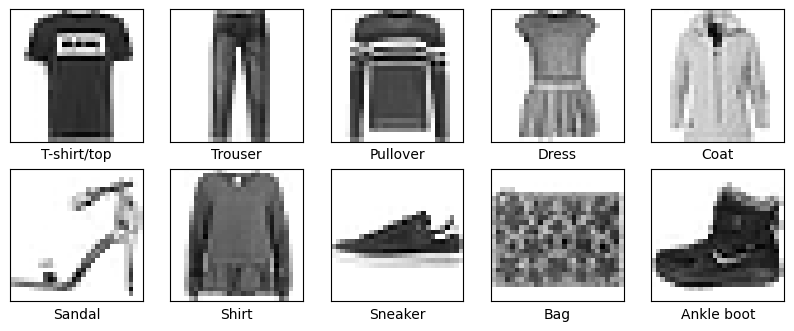

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb

# Login to Weights & Biases
wandb.login()

# Initialize W&B project
wandb.init(project='deep_learning_assignment_1',name='dataset_samples',mode='online')

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Define the class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
wandb.log({"examples":[wandb.Image(train_images[i],caption=class_labels[train_labels[i]])for i in range(10)]})
# Plot 1 sample image for each class
plt.figure(figsize=(10, 10))
for label in range(10):
    sample_image = train_images[train_labels == label][0]
    plt.subplot(5, 5, label + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(class_labels[label])
    plt.imshow(sample_image, cmap=plt.cm.binary)
plt.show()

# Finish the W&B run
wandb.finish()


In [4]:
from sklearn.model_selection import train_test_split

def tranform_dataset(train_images,train_labels,test_images,test_labels):
  #split the training dataset for traning and validation
  x_train,x_valid,y_train,y_valid=train_test_split(train_images,train_labels,test_size=0.1,random_state=42)
   #flattenten the image data
  x_train = x_train.reshape(x_train.shape[0], -1)
  x_valid = x_valid.reshape(x_valid.shape[0], -1)
  x_test = test_images.reshape(test_images.shape[0], -1)
  #Normalize the image data
  x_train = x_train.astype('float32') / 255
  x_valid = x_valid.astype('float32') / 255
  x_test = x_test.astype('float32') / 255
  # one hot encode for output column
  y_train = one_hot_encode(y_train)
  y_valid = one_hot_encode(y_valid)
  y_test = one_hot_encode(test_labels)


  return x_train,y_train,x_valid,y_valid,x_test,y_test



#one hot encoding for output
def one_hot_encode(labels):
    encoded = np.zeros((len(labels), 10))
    for i, label in enumerate(labels):
        encoded[i, label] = 1
    return encoded


In [5]:
#transform the dataset for using the feedforward neural network models
x_train,y_train,x_valid,y_valid,x_test,y_test=tranform_dataset(train_images,train_labels,test_images,test_labels)

In [6]:
#shapes of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)

x_train shape: (54000, 784)
y_train shape: (54000, 10)
x_valid shape: (6000, 784)
y_valid shape: (6000, 10)


Intialize a network

In [7]:
import numpy as np

def initial_weight(num_layer, hidden_size, weight_ini_method):
    # Create a list with num_layer hidden layers, each of size hidden_size
    network_size = [hidden_size] * num_layer
    # Prepend input size and append output size
    network_size = [x_train.shape[1]] + network_size + [y_train.shape[1]]
    print(network_size)  # Print the network architecture for debugging

    # Initialize an empty dictionary to store weights and biases
    theta = {}

    # Random initialization
    if weight_ini_method == "random":
        for i in range(len(network_size) - 1):
            # Weights: shape (current layer size, next layer size)
            theta[f'W{i+1}'] = np.random.randn(network_size[i], network_size[i+1])
            # Biases: shape (1, next layer size)
            theta[f'b{i+1}'] = np.random.randn(1, network_size[i+1])

    # Xavier (He-like) initialization
    elif weight_ini_method == "Xavier":
        for i in range(len(network_size) - 1):
            # Scaling factor based on input size (fan-in)
            scale = np.sqrt(2 / network_size[i])
            # Weights: random normal scaled by sqrt(2 / fan-in)
            theta[f'W{i+1}'] = np.random.randn(network_size[i], network_size[i+1]) * scale
            # Biases: random normal scaled by sqrt(2 / fan-in)
            theta[f'b{i+1}'] = np.random.randn(1, network_size[i+1]) * scale

    # Return the initialized parameters
    return theta

*Activation functiont**

In [8]:
def sigmoid(x):
  return 1 /(1 + np.exp(-x))

def relu(x):
  return np.maximum(0, x)

def tanh(x):
	return np.tanh(x)

def deriv_sigmoid(x):
  return sigmoid(x)*(1-sigmoid(x))

def deriv_relu(x):
  return np.where(x <= 0, 0, 1)

def deriv_tanh(x):
  return (1 - (tanh(x))**2)

def softmax(x):
  x = x - np.max(x,axis=1,keepdims=True)
  return np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)




def activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return sigmoid(x)
  elif activ_fun == 'relu':
    return relu(x)
  elif activ_fun=='softmax':
    return softmax(x)
  else:
    return tanh(x)

def deriv_activation(x, activ_fun):
  if activ_fun == 'sigmoid':
    return deriv_sigmoid(x)
  elif activ_fun == 'relu':
    return deriv_relu(x)
  else:
    return deriv_tanh(x)


Loss function

In [9]:
def cross_entropy(y_actual, y_pred):
   epsilon = 1e-15  # to prevent log(0) which is undefined
   y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
   loss = -np.mean(np.sum(y_actual * np.log(y_pred), axis=1))
   return loss
def mse_loss(y_actual,y_pred):
  return np.mean((y_actual-y_pred)**2)

In [10]:
def forward_prop(X, theta, active_fun_hidden, active_fun_output, num_layers):

  a = {}
  h = {'h0': X}
  for i in range(1, num_layers + 1):
    a[f'a{i}'] = np.dot(h[f'h{i-1}'], theta[f'W{i}']) + theta[f'b{i}']
    h[f'h{i}'] = activation(a[f'a{i}'], active_fun_hidden)
  a[f'a{num_layers+1}'] = np.dot(h[f'h{num_layers}'], theta[f'W{num_layers+1}']) + theta[f'b{num_layers+1}']
  y_pred = activation(a[f'a{num_layers+1}'], active_fun_output)
  return a, h, y_pred


In [11]:
# theta=initial_weight(5,[5]*5,"random")
# _,_,y_pred=forward_prop(x_train,theta,"sigmoid",'softmax',5)
# print(y_pred)

Calculate accuracy

In [12]:
def cal_accuracy(x,y,theta,active_fun_hidden,active_fun_output,num_layers):
    # Get the input size from X (number of features)
    input_size = x.shape[0]

    # Perform forward propagation to get predicted probabilities
    # We only need y_pred, so ignore other returned values with _
    _, _, y_pred = forward_prop(x, theta,
                               active_fun_hidden,active_fun_output,num_layers)

    # Get true class labels from one-hot encoded Y (index of 1 in each column)
    true_classes = np.argmax(y, axis=1)

    # Get predicted class labels from y_pred (index of max probability in each column)
    predicted_classes = np.argmax(y_pred, axis=1)

    # Calculate accuracy as the proportion of correct predictions
    accuracy = np.mean(predicted_classes == true_classes)

    return accuracy

Back_prop

In [13]:
def back_prop(x,y,theta,active_fun_hidden,active_fun_output,num_layers):
  m=x.shape[0]
  a,h,y_pred=forward_prop(x,theta,active_fun_hidden,active_fun_output,num_layers)
  grad_theta={}
  grad_h_a={}
  grad_h_a[f'a{num_layers+1}']=(y_pred-y)
  for i in range(num_layers+1,0,-1):
    grad_theta[f'W{i}']=np.dot(h[f'h{i-1}'].T,grad_h_a[f'a{i}'])
    grad_theta[f'b{i}']=np.sum(grad_h_a[f'a{i}'],axis=0,keepdims=True)

    if i>1:
      grad_h_a[f'h{i-1}']=np.dot(grad_h_a[f'a{i}'],theta[f'W{i}'].T)
      grad_h_a[f'a{i-1}']=grad_h_a[f'h{i-1}']*deriv_activation(a[f'a{i-1}'],active_fun_hidden)
  return grad_theta

Now we again write gradient decesent algorithm compatiable with batch size ,

In [14]:
def sgd(lr, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    # Initialize weights
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients and update weights
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)
            for j in range(1, num_layers + 2):
                theta[f'W{j}'] -= lr * (grad[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * grad[f'b{j}']
        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        # wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch + 1})

    # Final test accuracy
    test_accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test Accuracy: {test_accuracy * 100}')

    return theta, train_loss_history, val_loss_history


Moment Gradient descent (here momentum=beta)

In [15]:
def mgd(lr, momentum, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize velocity terms for weights and biases
    velocity = {}
    for i in range(1, num_layers + 2):
        velocity[f'W{i}'] = np.zeros_like(theta[f'W{i}'])
        velocity[f'b{i}'] = np.zeros_like(theta[f'b{i}'])

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Mini-batch training
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update weights and biases using momentum
            for j in range(1, num_layers + 2):
                velocity[f'W{j}'] = momentum * velocity[f'W{j}'] + grad[f'W{j}']
                velocity[f'b{j}'] = momentum * velocity[f'b{j}'] + grad[f'b{j}']

                theta[f'W{j}'] -= lr * (velocity[f'W{j}'] + weight_decay * theta[f'W{j}'])
                theta[f'b{j}'] -= lr * velocity[f'b{j}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store training loss
        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute and store validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch + 1})

    # Calculate final accuracy
    accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test accuracy: {accuracy}')

    return theta


**Nesterov accelerated gradient descent**

In [16]:
def nesterov_gd(lr, momentum, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs,loss_function='cross_entorpy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize velocity dictionary with zeros, matching the shape of each parameter
    velocity = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # List to store loss history
    loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Look ahead step for Nesterov momentum
            lookahead_theta = {key: theta[key] - momentum * velocity[key] for key in theta.keys()}

            # Compute gradients using backpropagation on the lookahead parameters
            grad = back_prop(x_batch, y_batch, lookahead_theta, active_fun_hidden, active_fun_output, num_layers)

            # Update velocities and parameters with Nesterov momentum and apply weight decay
            for k in range(1, num_layers + 2):
                # Update velocity for weights
                velocity[f'W{k}'] = momentum * velocity[f'W{k}'] + grad[f'W{k}'] + weight_decay * theta[f'W{k}']
                # Update weights using velocity
                theta[f'W{k}'] -= lr * velocity[f'W{k}']

                # Update velocity for biases
                velocity[f'b{k}'] = momentum * velocity[f'b{k}'] + grad[f'b{k}']
                # Update biases using velocity (no weight decay for biases)
                theta[f'b{k}'] -= lr * velocity[f'b{k}']

        # Compute the train accuracy
        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute training loss and predictions
        a, h, y_train_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        # Compute the validation accuracy
        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch+1}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100,'epoch':epoch+1})

    # Calculate final accuracy
    accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test accuracy: {accuracy}')

    # Plot the training and validation loss
    # plt.plot(loss_history, label='Training Loss')
    # plt.plot(val_loss_history, label='Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss over Epochs')
    # plt.legend()
    # plt.show()

    return theta, loss_history, val_loss_history

**RMS Prop**

In [17]:
def rmsprop(lr, gamma, epsilon, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method,weight_decay, epochs,loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize squared gradient dictionary with zeros, matching the shape of each parameter
    squared_grad = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store training and validation loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(epochs):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update squared gradients and parameters with RMSprop
            for k in range(1, num_layers + 2):
                # Update squared gradient for weights
                squared_grad[f'W{k}'] = gamma * squared_grad[f'W{k}'] + (1 - gamma) * (grad[f'W{k}'] ** 2)
                # Update weights using RMSprop
                theta[f'W{k}'] -= lr * (grad[f'W{k}'] / (np.sqrt(squared_grad[f'W{k}']) + epsilon) + weight_decay * theta[f'W{k}'])

                # Update squared gradient for biases
                squared_grad[f'b{k}'] = gamma * squared_grad[f'b{k}'] + (1 - gamma) * (grad[f'b{k}'] ** 2)
                # Update biases using RMSprop
                theta[f'b{k}'] -= lr * grad[f'b{k}'] / (np.sqrt(squared_grad[f'b{k}']) + epsilon)

       #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_train_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch+1 }, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss,"train_accuracy":train_accuracy*100,"val_accuracy":validation_accuracy*100,'epoch':epoch+1})

    # Calculate final accuracy on test set
    accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test accuracy: {accuracy}')



    return theta


**ADAM**

In [18]:
def adam(lr, beta1, beta2, epsilon, x_train, y_train, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs, loss_function='cross_entropy'):
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)
    train_loss_history = []
    val_loss_history = []

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]

        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Adam
            for k in range(1, num_layers + 2):
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                m_hat_W = m[f'W{k}'] / (1 - beta1 ** epoch)
                m_hat_b = m[f'b{k}'] / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                theta[f'W{k}'] -= lr * (m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        train_accuracy = cal_accuracy(x_train, y_train, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_train_pred = forward_prop(x_train, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_train_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_train_pred)
        train_loss_history.append(train_loss)

        validation_accuracy = cal_accuracy(x_val, y_val, theta, active_fun_hidden, active_fun_output, num_layers)

        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred) if loss_function == 'cross_entropy' else mse_loss(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "train_accuracy": train_accuracy * 100, "val_accuracy": validation_accuracy * 100, 'epoch': epoch})

    accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f'Test accuracy: {accuracy}')

    return theta


**NDAM**

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def nadam(lr, beta1, beta2, epsilon, x, y, x_val, y_val, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay,epochs,loss_function='cross_entropy'):
    # Initialize network parameters
    theta = initial_weight(num_layers, hidden_size, weight_ini_method)

    # Initialize first moment (m) and second moment (v) dictionaries with zeros
    m = {key: np.zeros_like(theta[key]) for key in theta.keys()}
    v = {key: np.zeros_like(theta[key]) for key in theta.keys()}

    # Lists to store loss history
    loss_history = []
    val_loss_history = []

    # Training loop over epochs
    for epoch in range(1, epochs + 1):
        # Shuffle training data
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

        for i in range(0, x.shape[0], batch_size):
            x_batch = x[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Compute gradients using backpropagation
            grad = back_prop(x_batch, y_batch, theta, active_fun_hidden, active_fun_output, num_layers)

            # Update first and second moment estimates and parameters with Nadam
            for k in range(1, num_layers + 2):
                # Update biased first moment estimate
                m[f'W{k}'] = beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']
                m[f'b{k}'] = beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']

                # Update biased second moment estimate
                v[f'W{k}'] = beta2 * v[f'W{k}'] + (1 - beta2) * (grad[f'W{k}'] ** 2)
                v[f'b{k}'] = beta2 * v[f'b{k}'] + (1 - beta2) * (grad[f'b{k}'] ** 2)

                # Compute bias-corrected first and second moment estimates with Nesterov acceleration
                m_hat_W = (beta1 * m[f'W{k}'] + (1 - beta1) * grad[f'W{k}']) / (1 - beta1 ** epoch)
                m_hat_b = (beta1 * m[f'b{k}'] + (1 - beta1) * grad[f'b{k}']) / (1 - beta1 ** epoch)
                v_hat_W = v[f'W{k}'] / (1 - beta2 ** epoch)
                v_hat_b = v[f'b{k}'] / (1 - beta2 ** epoch)

                # Update weights and biases
                theta[f'W{k}'] -= lr*(m_hat_W / (np.sqrt(v_hat_W) + epsilon) + weight_decay * theta[f'W{k}'])
                theta[f'b{k}'] -= lr * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

        #compute the train accuracy
        train_accuracy=cal_accuracy(x_train,y_train,theta,active_fun_hidden,active_fun_output,num_layers)

        # Compute training loss and predictions
        _, _, y_pred = forward_prop(x, theta, active_fun_hidden, active_fun_output, num_layers)
        train_loss = cross_entropy(y_train, y_pred) if loss_function == 'cross_entropy' else mse_loss(y_train, y_pred)
        loss_history.append(train_loss)

        #compute the validation accuracy
        validation_accuracy=cal_accuracy(x_val,y_val,theta,active_fun_hidden,active_fun_output,num_layers)


        # Compute validation loss
        _, _, y_val_pred = forward_prop(x_val, theta, active_fun_hidden, active_fun_output, num_layers)
        val_loss = cross_entropy(y_val, y_val_pred)
        val_loss_history.append(val_loss)

        # Print loss for monitoring
        print(f"Epoch {epoch}, Loss: {train_loss}, Validation Loss: {val_loss}")
        wandb.log({"train_loss": train_loss, "val_loss": val_loss,"train_accuracy":train_accuracy*100,"val_accuracy":validation_accuracy*100,'epoch':epoch})
    # Calculate final accuracy
    accuracy = cal_accuracy(x_test, y_test, theta, active_fun_hidden, active_fun_output, num_layers)
    print(f' accuracy: {accuracy}')



    return theta


**MOdel **

In [20]:
def model_training(lr, beta, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, optimizer, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs):

    if optimizer == 'sgd':
        theta = sgd(lr, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs)
    elif optimizer == 'momentum':
        theta = mgd(lr, beta, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs)
    elif optimizer == 'nag':
        theta = nesterov_gd(lr, beta, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs)
    elif optimizer == 'RMSprop':
        theta = rmsprop(lr, beta, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs)
    elif optimizer == 'adam':
        theta = adam(lr, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs)
    elif optimizer=='nadam':
      theta=nadam(lr, beta1, beta2, epsilon, x_train, y_train, x_valid, y_valid, batch_size, num_layers, hidden_size, active_fun_hidden, active_fun_output, weight_ini_method, weight_decay, epochs)
    return theta

In [ ]:
#Q2 and Q3 train a neural network with given hypermaters with cross entropy loss
#in question 2 intialize a neural network and pass a forward prop that will predict probabilities. here i run adam model , in there first it create
#a intial network and call backprop update weights , in back prop at first it will call forward prop then update weights and it will iterate as many epochs it has
#and give the accuracy, loss for train and valid dataset.
#---------uncomment the below code for run----------------
#wandb.init(project='deep_learning_assignment_1',name='adam-relu-softmax-random-layer-4-hid_size-32-epoch-5'')
#theta=adam(0.001,0.9,0.99,1e-8,x_train, y_train, x_valid, y_valid,32,4,'relu','softmax','random',0,5)
#wandb.finish()


In [21]:
sweep_config={
    'method':'bayes',#possible search random,grid
    'metric':{
        'name':'Valdiation_accuracy',
        'goal':'maximize'
    },
    'parameters':{
        'epochs':{
            'values':[5,10]

        },
      'hidden_size':{
            'values':[32, 64, 128]
        },
        'activation_hidden':{
            'values':['relu','sigmoid','tanh']
        },
        'activation_output':{
            'values':['softmax']
        },
        'weight_ini_method':{
            'values':['Xavier','random']
        },
        'batch_size':{
            'values':[16,32,64]
        }
      ,'num_layers':{
            'values':[3,4,5]
        },
        'weight_decay':{
            'values':[0]#(we take l2 regulraization as zero)
        } ,
        'learning_rate':{
            'values':[1e-3,1e-4]
      }
        ,'optimizer':{
            'values':['sgd','momentum','nag','RMSprop','adam','nadam']
}
    }
}
sweep_id=wandb.sweep(sweep_config,project='deep_learning_assignment_1')

Create sweep with ID: xd33zmtu
Sweep URL: https://wandb.ai/bgorai005-iit-madras/deep_learning_assignment_1/sweeps/xd33zmtu


In [22]:
def main():
  with wandb.init() as run:
    run_name=f"ac-{wandb.config.activation_hidden}_hs-{wandb.config.hidden_size}_epc-{wandb.config.epochs}_nl-{wandb.config.num_layers}_lr{wandb.config.learning_rate}_wd-{wandb.config.weight_decay}_opt-{wandb.config.optimizer}_bs-{wandb.config.batch_size}_wi-{wandb.config.weight_ini_method}"
    wandb.run.name=run_name

    model_training(wandb.config.learning_rate,0.9,0.9,0.99,1e-8,x_train,y_train,x_valid,y_valid,wandb.config.optimizer,wandb.config.batch_size,wandb.config.num_layers,wandb.config.hidden_size,wandb.config.activation_hidden,wandb.config.activation_output,wandb.config.weight_ini_method,wandb.config.weight_decay,wandb.config.epochs)

try:
    wandb.agent(sweep_id,function=main,count=40)
    wandb.finish()
except BrokenPipeError:
    print("Encountered a BrokenPipeError. Attempting to gracefully finish the run.")
    # You can add additional error handling logic here, such as saving intermediate results
    wandb.finish(quiet=True)  # Try finishing quietly to avoid further errors

wandb: Agent Starting Run: xbn030cc with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.4335385714741053, Val Loss: 0.4472559765764906
Epoch 2, Train Loss: 0.4333111003661983, Val Loss: 0.4490536660993083
Epoch 3, Train Loss: 0.37875115980568397, Val Loss: 0.3987406362118386
Epoch 4, Train Loss: 0.35738869607959856, Val Loss: 0.3841254939456394
Epoch 5, Train Loss: 0.34899578215711285, Val Loss: 0.37593500609748964
Test accuracy: 0.853


epoch,▁▃▅▆█
train_accuracy,▃▁▆▇█
train_loss,██▃▂▁
val_accuracy,▃▁▆▆█
val_loss,██▃▂▁
epoch,5
train_accuracy,87.25741
train_loss,0.349
val_accuracy,86.68333
val_loss,0.37594


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9r1hgq4c with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 9.53329456563213, Validation Loss: 0.4238189482673716
Epoch 2, Loss: 11.333162936737269, Validation Loss: 0.4160223926869669
Epoch 3, Loss: 11.876498850229972, Validation Loss: 0.35825566833340783
Epoch 4, Loss: 12.516838058668997, Validation Loss: 0.3824886145440105
Epoch 5, Loss: 13.021505979062768, Validation Loss: 0.35996167496016157
Epoch 6, Loss: 13.29742265380877, Validation Loss: 0.34679078612860287
Epoch 7, Loss: 14.189812414566125, Validation Loss: 0.356150329704876
Epoch 8, Loss: 14.89230534460388, Validation Loss: 0.367934966924619
Epoch 9, Loss: 14.95657877339094, Validation Loss: 0.34551391530708475
Epoch 10, Loss: 14.507271820141034, Validation Loss: 0.3433344448704371
 accuracy: 0.8664


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▅▄▆▇▇▆▇█
train_loss,▁▃▄▅▆▆▇██▇
val_accuracy,▁▁▆▅▆▇▆▅██
val_loss,█▇▂▄▂▁▂▃▁▁
epoch,10
train_accuracy,89.79444
train_loss,14.50727
val_accuracy,88.06667
val_loss,0.34333


wandb: Agent Starting Run: apzfd9ml with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.45202467581435835, Val Loss: 0.46452980540056116
Epoch 2, Train Loss: 0.39978143762139823, Val Loss: 0.4189221837939364
Epoch 3, Train Loss: 0.3993331148549371, Val Loss: 0.41932255062887996
Epoch 4, Train Loss: 0.3490458086917652, Val Loss: 0.3746798302882706
Epoch 5, Train Loss: 0.33586238124522005, Val Loss: 0.3663364671280317
Epoch 6, Train Loss: 0.36755025711969397, Val Loss: 0.410911847243589
Epoch 7, Train Loss: 0.3434591890696666, Val Loss: 0.3854415320557101
Epoch 8, Train Loss: 0.31604710733905494, Val Loss: 0.36095119862413994
Epoch 9, Train Loss: 0.29573050437766296, Val Loss: 0.34248008695762217
Epoch 10, Train Loss: 0.3316017248810285, Val Loss: 0.39061802964900894
Test accuracy: 0.8544


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▅▆▄▆▇█▆
train_loss,█▆▆▃▃▄▃▂▁▃
val_accuracy,▁▄▃▅▆▄▅▆█▆
val_loss,█▅▅▃▂▅▃▂▁▄
epoch,10
train_accuracy,87.8963
train_loss,0.3316
val_accuracy,86.5
val_loss,0.39062


wandb: Agent Starting Run: jnmfwt2e with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 31.03316843946913, Validation Loss: 14.487500734119365
Epoch 2, Loss: 30.983832133957495, Validation Loss: 12.88831555385545
Epoch 3, Loss: 31.049409366668073, Validation Loss: 12.21152652730433
Epoch 4, Loss: 31.06546014760979, Validation Loss: 11.611871177321074
Epoch 5, Loss: 31.14247242241098, Validation Loss: 11.351139051939851
 accuracy: 0.6759


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,▃▁▄▅█
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,68.51296
train_loss,31.14247
val_accuracy,66.88333
val_loss,11.35114


wandb: Agent Starting Run: x4lut4fi with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 2.8509875052562896, Val Loss: 2.9087032744537367
Epoch 2, Train Loss: 2.009556617505747, Val Loss: 2.0273369546529527
Epoch 3, Train Loss: 1.648853335113416, Val Loss: 1.7241275021319051
Epoch 4, Train Loss: 1.4484605138315423, Val Loss: 1.5411871849834708
Epoch 5, Train Loss: 1.3181958943858014, Val Loss: 1.4092953613806625
Test Accuracy: 59.53000000000001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y2jkas3h with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 1.3166489965973014, Val Loss: 1.3421847109797098
Epoch 2, Train Loss: 1.1148488466890871, Val Loss: 1.1335591571234893
Epoch 3, Train Loss: 1.0808335288340873, Val Loss: 1.0936039390834111
Epoch 4, Train Loss: 0.9354993508572383, Val Loss: 0.9567335808359979
Epoch 5, Train Loss: 0.9135715193244007, Val Loss: 0.9253284167661324
Test Accuracy: 65.93


wandb: Agent Starting Run: jynjb5a5 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Loss: 31.00367021650215, Validation Loss: 7.862003763293087
Epoch 2, Loss: 30.90627383460012, Validation Loss: 7.221717985672981
Epoch 3, Loss: 30.85638120636756, Validation Loss: 6.965105546055456
Epoch 4, Loss: 30.825322170735834, Validation Loss: 6.712591216786604
Epoch 5, Loss: 30.784495146259832, Validation Loss: 7.065313034761442
 accuracy: 0.7648


epoch,▁▃▅▆█
train_accuracy,▁▆▆█▆
train_loss,█▅▃▂▁
val_accuracy,▂█▇▇▁
val_loss,█▄▃▁▃
epoch,5
train_accuracy,79.38889
train_loss,30.7845
val_accuracy,76.08333
val_loss,7.06531


wandb: Agent Starting Run: 3qttgp58 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 3.30071067040283, Validation Loss: 1.3543099991698462
Epoch 2, Loss: 4.129934269082031, Validation Loss: 1.0717493287835849
Epoch 3, Loss: 4.5327437696229085, Validation Loss: 0.8949403209541338
Epoch 4, Loss: 5.045800435940473, Validation Loss: 0.7932392404585051
Epoch 5, Loss: 5.367018450610292, Validation Loss: 0.71914207395434
 accuracy: 0.7454


epoch,▁▃▅▆█
train_accuracy,▁▂▆▇█
train_loss,▁▄▅▇█
val_accuracy,▁▃▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,75.57593
train_loss,5.36702
val_accuracy,74.78333
val_loss,0.71914


wandb: Agent Starting Run: idr5hty4 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Train Loss: 2.274691498269505, Val Loss: 2.2758509656374146
Epoch 2, Train Loss: 2.238456670467317, Val Loss: 2.239069988435424
Epoch 3, Train Loss: 2.171659458348459, Val Loss: 2.1739672284903024
Epoch 4, Train Loss: 2.0376796984855376, Val Loss: 2.0414404364487435
Epoch 5, Train Loss: 1.8406101899232723, Val Loss: 1.8471528354188516
Test Accuracy: 43.169999999999995


wandb: Agent Starting Run: udu3mkf2 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]


<ipython-input-8-867b69375f18>:2: RuntimeWarning: overflow encountered in exp
  return 1 /(1 + np.exp(-x))


Epoch 1, Loss: 0.09054650146412269, Validation Loss: 0.09063952083502409
Epoch 2, Loss: 0.09093093455390899, Validation Loss: 0.09083552660138965
Epoch 3, Loss: 0.09112062074287987, Validation Loss: 0.09105875362737137
Epoch 4, Loss: 0.09176632156405565, Validation Loss: 0.09154936697702133
Epoch 5, Loss: 0.09068216539074028, Validation Loss: 0.09057870280449795
Test accuracy: 0.1


epoch,▁▃▅▆█
train_accuracy,█▄▄▁▁
train_loss,▁▃▄█▂
val_accuracy,▁▅▅██
val_loss,▁▃▄█▁
epoch,5
train_accuracy,9.95
train_loss,0.09068
val_accuracy,10.45
val_loss,0.09058


wandb: Agent Starting Run: x32berst with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 1.0662380432055074, Val Loss: 1.0610921009531378
Epoch 2, Train Loss: 0.9335290972303073, Val Loss: 0.9465378574029155
Epoch 3, Train Loss: 0.8596796427820141, Val Loss: 0.8851494663452706
Epoch 4, Train Loss: 0.8196811827482754, Val Loss: 0.8388301586414227
Epoch 5, Train Loss: 0.7807570267977839, Val Loss: 0.8122945183861003
Test Accuracy: 70.55


wandb: Agent Starting Run: e1l4w2jf with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 1.1057291491341645, Val Loss: 1.1258496879926396
Epoch 2, Train Loss: 0.8644305771052195, Val Loss: 0.894012293043637
Epoch 3, Train Loss: 0.775580280401691, Val Loss: 0.8047184545264578
Epoch 4, Train Loss: 0.7277044259314556, Val Loss: 0.7574065710688189
Epoch 5, Train Loss: 0.6694112667737574, Val Loss: 0.6977561067599205
Epoch 6, Train Loss: 0.6521862461942454, Val Loss: 0.6727456691291384
Epoch 7, Train Loss: 0.625931607781181, Val Loss: 0.6721430473380073
Epoch 8, Train Loss: 0.607056151327304, Val Loss: 0.640216904376438
Epoch 9, Train Loss: 0.5874094447459529, Val Loss: 0.6289760279048963
Epoch 10, Train Loss: 0.5709461527693627, Val Loss: 0.6045742904403903
Test accuracy: 0.7798


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇▇█
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,79.80741
train_loss,0.57095
val_accuracy,79.1
val_loss,0.60457


wandb: Agent Starting Run: onlr3k70 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 13.684830078788252, Validation Loss: 0.4783642316457837
Epoch 2, Loss: 14.767307087957521, Validation Loss: 0.45571140780558966
Epoch 3, Loss: 18.955866810746738, Validation Loss: 0.4868938744924542
Epoch 4, Loss: 19.814146642410318, Validation Loss: 0.6760861553736437
Epoch 5, Loss: 19.423627836464195, Validation Loss: 0.6044070309589625
Epoch 6, Loss: 21.506033865371744, Validation Loss: 0.6097773225437121
Epoch 7, Loss: 20.940117860818244, Validation Loss: 0.5016309031038033
Epoch 8, Loss: 19.27183457007979, Validation Loss: 0.7114184539769514
Epoch 9, Loss: 21.343242420065422, Validation Loss: 0.7064010919251184
Epoch 10, Loss: 19.790297183477623, Validation Loss: 0.6304972820854948
Test accuracy: 0.7854


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▄▇█▅▃▆█▁▅▁
train_loss,▁▂▆▆▆█▇▆█▆
val_accuracy,▅▇█▆▄▅█▁▅▁
val_loss,▂▁▂▇▅▅▂██▆
epoch,10
train_accuracy,80.11667
train_loss,19.7903
val_accuracy,78.96667
val_loss,0.6305


wandb: Agent Starting Run: ks05kiz6 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 1.5428300629494345, Val Loss: 1.5815886297944355
Epoch 2, Train Loss: 1.0609116849514788, Val Loss: 1.0682678657861
Epoch 3, Train Loss: 0.9102291457522936, Val Loss: 0.9516678780278531
Epoch 4, Train Loss: 0.8245475197854111, Val Loss: 0.8647280342064613
Epoch 5, Train Loss: 0.7737831652937539, Val Loss: 0.8163563870919418
Test accuracy: 0.7075


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▂▁▁
val_accuracy,▁▅▆▇█
val_loss,█▃▂▁▁
epoch,5
train_accuracy,71.72593
train_loss,0.77378
val_accuracy,71
val_loss,0.81636


wandb: Agent Starting Run: 04a4kdyl with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 10.87375330841626, Val Loss: 11.274245559341296
Epoch 2, Train Loss: 9.716286670717293, Val Loss: 10.085322707313919
Epoch 3, Train Loss: 9.201674814149401, Val Loss: 9.667025385686973
Epoch 4, Train Loss: 8.911416827130942, Val Loss: 9.408654188878842
Epoch 5, Train Loss: 8.54624016946789, Val Loss: 9.064465248394301
Test accuracy: 0.731


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,75.23889
train_loss,8.54624
val_accuracy,73.73333
val_loss,9.06447


wandb: Agent Starting Run: xerav6vm with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Loss: 8.139422584573405, Validation Loss: 1.3760334746559209
Epoch 2, Loss: 8.437806040417497, Validation Loss: 1.015753063794753
Epoch 3, Loss: 8.565327560041938, Validation Loss: 0.8990584569256225
Epoch 4, Loss: 8.759336102764044, Validation Loss: 0.836388945952012
Epoch 5, Loss: 8.735937934407307, Validation Loss: 0.7987318826719229
 accuracy: 0.7237


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,▁▄▆██
val_accuracy,▁▅▆▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,74.39444
train_loss,8.73594
val_accuracy,72.58333
val_loss,0.79873


wandb: Agent Starting Run: 0pc5pa34 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 13.04758344678722, Validation Loss: 4.721349836763211
Epoch 2, Loss: 10.945021966079409, Validation Loss: 2.7682640448710916
Epoch 3, Loss: 9.052041454004002, Validation Loss: 1.758598147166032
Epoch 4, Loss: 8.724381485288124, Validation Loss: 1.2933124696228244
Epoch 5, Loss: 8.52739527364218, Validation Loss: 1.1413267119659576
Test accuracy: 0.5881


epoch,▁▃▅▆█
train_accuracy,▁▃▄▆█
train_loss,█▅▂▁▁
val_accuracy,▁▃▅▇█
val_loss,█▄▂▁▁
epoch,5
train_accuracy,59.30741
train_loss,8.5274
val_accuracy,58.1
val_loss,1.14133


wandb: Agent Starting Run: 33gf96tk with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Loss: 6.440021831823253, Validation Loss: 0.41002620860707867
Epoch 2, Loss: 6.835927793542052, Validation Loss: 0.40119860802216334
Epoch 3, Loss: 7.138888866253165, Validation Loss: 0.35539385444387295
Epoch 4, Loss: 7.466147156285812, Validation Loss: 0.34036938263908184
Epoch 5, Loss: 7.66909812928296, Validation Loss: 0.35540577348637603
 accuracy: 0.8648


epoch,▁▃▅▆█
train_accuracy,▁▂▅██
train_loss,▁▃▅▇█
val_accuracy,▁▁▅█▆
val_loss,█▇▃▁▃
epoch,5
train_accuracy,89.02778
train_loss,7.6691
val_accuracy,86.96667
val_loss,0.35541


wandb: Agent Starting Run: 8ksswvy7 with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Loss: 7.461314187365576, Validation Loss: 0.5186397261577704
Epoch 2, Loss: 8.320487464076978, Validation Loss: 0.4608794563635472
Epoch 3, Loss: 8.842326669263178, Validation Loss: 0.43250033177467184
Epoch 4, Loss: 9.115862719963443, Validation Loss: 0.41399458953353935
Epoch 5, Loss: 9.384153384541438, Validation Loss: 0.40195179126088854
Epoch 6, Loss: 9.6379052590697, Validation Loss: 0.39703995441865353
Epoch 7, Loss: 9.789279327061704, Validation Loss: 0.3896361599166767
Epoch 8, Loss: 9.938226090797283, Validation Loss: 0.3786902886552193
Epoch 9, Loss: 10.086489858547033, Validation Loss: 0.3770969169287525
Epoch 10, Loss: 10.087555560754291, Validation Loss: 0.3719665162100958
 accuracy: 0.8604


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▆▇▇██
train_loss,▁▃▅▅▆▇▇███
val_accuracy,▁▃▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,87.93148
train_loss,10.08756
val_accuracy,87.11667
val_loss,0.37197


wandb: Agent Starting Run: 9ini2zub with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 10]
Epoch 1, Loss: 2.885868395955922, Validation Loss: 1.299030296930577
Epoch 2, Loss: 3.564465579048604, Validation Loss: 0.943726342578529
Epoch 3, Loss: 4.033793020110647, Validation Loss: 0.7728241198635942
Epoch 4, Loss: 4.438865324162616, Validation Loss: 0.6792847915064975
Epoch 5, Loss: 4.711537760028959, Validation Loss: 0.6208929318211172
 accuracy: 0.7761


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,▁▄▅▇█
val_accuracy,▁▅▆▇█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,78.72222
train_loss,4.71154
val_accuracy,78.01667
val_loss,0.62089


wandb: Agent Starting Run: exrtdzlg with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.5392850477348656, Val Loss: 0.5554192487556593
Epoch 2, Train Loss: 0.4386242293611668, Val Loss: 0.4578683658942902
Epoch 3, Train Loss: 0.3992268544344314, Val Loss: 0.42602527886377306
Epoch 4, Train Loss: 0.3583258715535974, Val Loss: 0.3861876621864389
Epoch 5, Train Loss: 0.34070680874387355, Val Loss: 0.37000644974587643
Epoch 6, Train Loss: 0.3519913769634565, Val Loss: 0.39630397908449244
Epoch 7, Train Loss: 0.3462502747244055, Val Loss: 0.38751673921967966
Epoch 8, Train Loss: 0.3044903470037733, Val Loss: 0.35830208708652217
Epoch 9, Train Loss: 0.3414637141212407, Val Loss: 0.38713792956121096
Epoch 10, Train Loss: 0.3036715974225757, Val Loss: 0.35686732958584466
Test accuracy: 0.8628


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▇▇▇▇█▇█
train_loss,█▅▄▃▂▂▂▁▂▁
val_accuracy,▁▄▅▆▇▇▇█▇█
val_loss,█▅▃▂▁▂▂▁▂▁
epoch,10
train_accuracy,88.9037
train_loss,0.30367
val_accuracy,87.51667
val_loss,0.35687


wandb: Agent Starting Run: thfu9etc with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]


<ipython-input-8-867b69375f18>:20: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x,axis=1,keepdims=True)


Epoch 1, Train Loss: nan, Val Loss: nan
Epoch 2, Train Loss: nan, Val Loss: nan
Epoch 3, Train Loss: nan, Val Loss: nan
Epoch 4, Train Loss: nan, Val Loss: nan
Epoch 5, Train Loss: nan, Val Loss: nan
Test Accuracy: 10.0


wandb: Agent Starting Run: gjkcop4u with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.47446056268590664, Val Loss: 0.4845738483043633
Epoch 2, Train Loss: 0.4367980162869416, Val Loss: 0.45133054109755155
Epoch 3, Train Loss: 0.4276032577454806, Val Loss: 0.45730039314884213
Epoch 4, Train Loss: 0.36597689634586755, Val Loss: 0.3960277099014398
Epoch 5, Train Loss: 0.37400271657630607, Val Loss: 0.4179684783613276
Test accuracy: 0.8485


epoch,▁▃▅▆█
train_accuracy,▁▃▂▇█
train_loss,█▆▅▁▂
val_accuracy,▁▂▁▇█
val_loss,█▅▆▁▃
epoch,5
train_accuracy,87.1037
train_loss,0.374
val_accuracy,86
val_loss,0.41797


wandb: Agent Starting Run: xmljdcnc with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 0.15136026113072448, Validation Loss: 0.15194865188112644
Epoch 2, Loss: 0.13712684495035196, Validation Loss: 0.13827667463238744
Epoch 3, Loss: 0.172162149246056, Validation Loss: 0.1682039763335212
Epoch 4, Loss: 0.17816893928308747, Validation Loss: 0.18000756574617235
Epoch 5, Loss: 0.1778582111851814, Validation Loss: 0.179694885118478
Epoch 6, Loss: 0.1469104540208526, Validation Loss: 0.14844208947592177
Epoch 7, Loss: 0.12057639194353316, Validation Loss: 0.12158853772640883
Epoch 8, Loss: 0.1371820463950541, Validation Loss: 0.13770452137663147
Epoch 9, Loss: 0.13652344130734054, Validation Loss: 0.1369751949853397
Epoch 10, Loss: 0.14871049097013178, Validation Loss: 0.14918703319955307
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃█▂▂▂▂▂▂▂
train_loss,▅▃▇██▄▁▃▃▄
val_accuracy,▂▄█▁▁▁▁▃▃▃
val_loss,▅▃▇██▄▁▃▃▄
epoch,10
train_accuracy,10.02407
train_loss,0.14871
val_accuracy,9.78333
val_loss,0.14919


wandb: Agent Starting Run: f5922fls with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 10]
Epoch 1, Train Loss: 0.8503795307279051, Val Loss: 0.8590620367269612
Epoch 2, Train Loss: 0.8966426025041343, Val Loss: 0.9262033635405275
Epoch 3, Train Loss: 0.7571107995706324, Val Loss: 0.7652723317570963
Epoch 4, Train Loss: 0.7957022344596407, Val Loss: 0.8076831064436456
Epoch 5, Train Loss: 0.6821544278072976, Val Loss: 0.7069941861969207
Test accuracy: 0.7508


epoch,▁▃▅▆█
train_accuracy,▂▁▇▇█
train_loss,▆█▃▅▁
val_accuracy,▃▁███
val_loss,▆█▃▄▁
epoch,5
train_accuracy,76.0537
train_loss,0.68215
val_accuracy,74.16667
val_loss,0.70699


wandb: Agent Starting Run: helr5kub with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 10]
Epoch 1, Loss: 7.167799734773712, Validation Loss: 0.4096097933829885
Epoch 2, Loss: 7.477181586248949, Validation Loss: 0.37450360149196066
Epoch 3, Loss: 8.053404363310984, Validation Loss: 0.3538197410666288
Epoch 4, Loss: 8.076853256781485, Validation Loss: 0.3260440087013798
Epoch 5, Loss: 8.350510898588649, Validation Loss: 0.33883489777523607
 accuracy: 0.8685


epoch,▁▃▅▆█
train_accuracy,▁▄▆██
train_loss,▁▃▆▆█
val_accuracy,▁▃▅█▆
val_loss,█▅▃▁▂
epoch,5
train_accuracy,89.08519
train_loss,8.35051
val_accuracy,87.85
val_loss,0.33883


wandb: Agent Starting Run: pkuhppr9 with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 5.213083437526773, Validation Loss: 1.2428486324991437
Epoch 2, Loss: 5.387105512058871, Validation Loss: 0.9997093979234135
Epoch 3, Loss: 5.556789679553177, Validation Loss: 0.9124289298970973
Epoch 4, Loss: 5.623511550220844, Validation Loss: 0.8638130517888314
Epoch 5, Loss: 5.706732132337128, Validation Loss: 0.8178178410762476
 accuracy: 0.6861


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,▁▃▆▇█
val_accuracy,▁▄▆▆█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,69.84815
train_loss,5.70673
val_accuracy,69.66667
val_loss,0.81782


wandb: Agent Starting Run: n3qxstua with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 5.725296227697104, Validation Loss: 0.432760592676646
Epoch 2, Loss: 6.1786887754265, Validation Loss: 0.3832794156764261
Epoch 3, Loss: 6.36194319838858, Validation Loss: 0.3787666428266193
Epoch 4, Loss: 6.543561386565097, Validation Loss: 0.35518133275910924
Epoch 5, Loss: 6.748981361288608, Validation Loss: 0.34921277296001735
Epoch 6, Loss: 6.845744634999279, Validation Loss: 0.34014755992352497
Epoch 7, Loss: 6.8785186449198585, Validation Loss: 0.33451875113612045
Epoch 8, Loss: 6.999773129385286, Validation Loss: 0.33583553797125404
Epoch 9, Loss: 7.1519676620451165, Validation Loss: 0.3290960884917016
Epoch 10, Loss: 7.250020539226659, Validation Loss: 0.32634878341092916
 accuracy: 0.8691


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▅▆▇▇▇██
train_loss,▁▃▄▅▆▆▆▇██
val_accuracy,▁▅▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,89.62778
train_loss,7.25002
val_accuracy,88.01667
val_loss,0.32635


wandb: Agent Starting Run: kqodbdlu with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 1.6538053911789994, Val Loss: 1.6531153728335752
Epoch 2, Train Loss: 1.3052962492696538, Val Loss: 1.3061063814273015
Epoch 3, Train Loss: 1.1184917364636657, Val Loss: 1.1194282665140949
Epoch 4, Train Loss: 1.0061510204196087, Val Loss: 1.0057351609509135
Epoch 5, Train Loss: 0.933502167366311, Val Loss: 0.9343461629610589
Epoch 6, Train Loss: 0.8823074220322774, Val Loss: 0.8844505731017925
Epoch 7, Train Loss: 0.8425956668939424, Val Loss: 0.8448185198294392
Epoch 8, Train Loss: 0.810851475033908, Val Loss: 0.813771400698343
Epoch 9, Train Loss: 0.7842414222122237, Val Loss: 0.7880081039671165
Epoch 10, Train Loss: 0.7617194564718458, Val Loss: 0.7655671237445937
Test accuracy: 0.7254


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
train_accuracy,73.37593
train_loss,0.76172
val_accuracy,72.15
val_loss,0.76557


wandb: Agent Starting Run: rj1ieiu9 with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 3.2027487683869054, Validation Loss: 1.3202698782023345
Epoch 2, Loss: 4.212112261967574, Validation Loss: 0.9673439432891969
Epoch 3, Loss: 4.95778065549623, Validation Loss: 0.7574240684061225
Epoch 4, Loss: 5.5936323114383235, Validation Loss: 0.6367765731182549
Epoch 5, Loss: 6.041986103275417, Validation Loss: 0.5748922950553675
Test accuracy: 0.7838


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,▁▃▅▇█
val_accuracy,▁▅▇▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,79.27593
train_loss,6.04199
val_accuracy,78.16667
val_loss,0.57489


wandb: Agent Starting Run: 8vf80vad with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 10]
Epoch 1, Train Loss: 2.289132446834749, Val Loss: 2.2939107260860885
Epoch 2, Train Loss: 1.7470325781373337, Val Loss: 1.746327146841346
Epoch 3, Train Loss: 2.12826754745798, Val Loss: 2.1294452753784965
Epoch 4, Train Loss: 1.8048962136572289, Val Loss: 1.8234040771374493
Epoch 5, Train Loss: 2.7192911394671015, Val Loss: 2.7268936675691138
Test accuracy: 0.1


epoch,▁▃▅▆█
train_accuracy,▆█▅▇▁
train_loss,▅▁▄▁█
val_accuracy,▆█▅▆▁
val_loss,▅▁▄▂█
epoch,5
train_accuracy,10.02407
train_loss,2.71929
val_accuracy,9.78333
val_loss,2.72689


wandb: Agent Starting Run: gldnk1ye with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.4107978952987612, Val Loss: 0.42640898163369534
Epoch 2, Train Loss: 0.34715221171783694, Val Loss: 0.37917583691053336
Epoch 3, Train Loss: 0.35513022152570894, Val Loss: 0.3866672960117037
Epoch 4, Train Loss: 0.30027634033071887, Val Loss: 0.34436215448451524
Epoch 5, Train Loss: 0.2921127542347969, Val Loss: 0.345154327133831
Epoch 6, Train Loss: 0.28718521087947363, Val Loss: 0.3492437490343559
Epoch 7, Train Loss: 0.27164182329897146, Val Loss: 0.33929224562569577
Epoch 8, Train Loss: 0.28127767535741716, Val Loss: 0.3550679536211905
Epoch 9, Train Loss: 0.2705062646517946, Val Loss: 0.3552377557835528
Epoch 10, Train Loss: 0.24867324031274912, Val Loss: 0.33851043411982296
Test accuracy: 0.8764


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▃▆▆▆▇▆▇█
train_loss,█▅▆▃▃▃▂▂▂▁
val_accuracy,▁▄▃▆▇▇▇▆▆█
val_loss,█▄▅▁▂▂▁▂▂▁
epoch,10
train_accuracy,90.89444
train_loss,0.24867
val_accuracy,88.31667
val_loss,0.33851


wandb: Agent Starting Run: fo74c9bl with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 10]
Epoch 1, Train Loss: 1.6154744400343868, Val Loss: 1.623362587740966
Epoch 2, Train Loss: 1.1441029720123685, Val Loss: 1.1530246989254265
Epoch 3, Train Loss: 0.9196982504677412, Val Loss: 0.9281454421711972
Epoch 4, Train Loss: 0.7540904694979006, Val Loss: 0.7633963392881234
Epoch 5, Train Loss: 0.6468779918687236, Val Loss: 0.655668881711867
Test accuracy: 0.7607


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,77.34074
train_loss,0.64688
val_accuracy,76.55
val_loss,0.65567


wandb: Agent Starting Run: 6ynv43aw with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 64, 64, 64, 64, 10]
Epoch 1, Loss: 9.085875417214304, Validation Loss: 0.4118361465686155
Epoch 2, Loss: 9.907154205553981, Validation Loss: 0.35596906113528093
Epoch 3, Loss: 10.849941851430284, Validation Loss: 0.35866069458003424
Epoch 4, Loss: 11.283126409525298, Validation Loss: 0.3327098855578608
Epoch 5, Loss: 11.842539180274699, Validation Loss: 0.33893150253117504
Epoch 6, Loss: 12.603585311147901, Validation Loss: 0.3666751388048018
Epoch 7, Loss: 13.211001575585485, Validation Loss: 0.3436447896986659
Epoch 8, Loss: 14.006393254871256, Validation Loss: 0.3307720400616371
Epoch 9, Loss: 13.476307809718318, Validation Loss: 0.32089610206644803
Epoch 10, Loss: 14.042279556871039, Validation Loss: 0.32617697822817715
 accuracy: 0.8786


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▆▆▅▆▇██
train_loss,▁▂▃▄▅▆▇█▇█
val_accuracy,▁▅▅▇▆▄▇▇██
val_loss,█▄▄▂▂▅▃▂▁▁
epoch,10
train_accuracy,91.21667
train_loss,14.04228
val_accuracy,88.63333
val_loss,0.32618


wandb: Agent Starting Run: w68n1auh with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: nag
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.1684894766212841, Validation Loss: 0.16704524289293593
Epoch 2, Loss: 0.16270635218235094, Validation Loss: 0.16125245765157378
Epoch 3, Loss: 0.1489096683920143, Validation Loss: 0.1499360765694832
Epoch 4, Loss: 0.1373682500610546, Validation Loss: 0.1335838790964387
Epoch 5, Loss: 0.17018003223684977, Validation Loss: 0.17414368939228553
Test accuracy: 0.1


epoch,▁▃▅▆█
train_accuracy,▄▅▁█▄
train_loss,█▆▃▁█
val_accuracy,▅▅▁█▁
val_loss,▇▆▄▁█
epoch,5
train_accuracy,10.09259
train_loss,0.17018
val_accuracy,9.16667
val_loss,0.17414


wandb: Agent Starting Run: 2i6ox6mc with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 64, 64, 64, 64, 64, 10]
Epoch 1, Train Loss: nan, Val Loss: nan
Epoch 2, Train Loss: nan, Val Loss: nan
Epoch 3, Train Loss: nan, Val Loss: nan
Epoch 4, Train Loss: nan, Val Loss: nan
Epoch 5, Train Loss: nan, Val Loss: nan
Epoch 6, Train Loss: nan, Val Loss: nan
Epoch 7, Train Loss: nan, Val Loss: nan
Epoch 8, Train Loss: nan, Val Loss: nan
Epoch 9, Train Loss: nan, Val Loss: nan
Epoch 10, Train Loss: nan, Val Loss: nan
Test accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,10
train_accuracy,10.00556
train_loss,nan
val_accuracy,9.95
val_loss,nan


wandb: Agent Starting Run: t4ve4t2a with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.5710982151948595, Val Loss: 0.5794619640991191
Epoch 2, Train Loss: 0.5471592580169856, Val Loss: 0.5681994823542829
Epoch 3, Train Loss: 0.4887016307044027, Val Loss: 0.5180642705877285
Epoch 4, Train Loss: 0.5156184761752522, Val Loss: 0.5482079286028724
Epoch 5, Train Loss: 0.5210754366485859, Val Loss: 0.5500462312120152
Test accuracy: 0.8068


epoch,▁▃▅▆█
train_accuracy,▁▃█▆▇
train_loss,█▆▁▃▄
val_accuracy,▁▄█▆▇
val_loss,█▇▁▄▅
epoch,5
train_accuracy,82.07037
train_loss,0.52108
val_accuracy,81.05
val_loss,0.55005


wandb: Agent Starting Run: rd22524n with config:
wandb: 	activation_hidden: tanh
wandb: 	activation_output: softmax
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 4
wandb: 	optimizer: RMSprop
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Loss: 3.99229731078915, Validation Loss: 0.6213404218010298
Epoch 2, Loss: 4.7571758943538445, Validation Loss: 0.5126051491546709
Epoch 3, Loss: 5.126829040512893, Validation Loss: 0.45645526555498206
Epoch 4, Loss: 5.408240009329388, Validation Loss: 0.42864045641073234
Epoch 5, Loss: 5.632626563780442, Validation Loss: 0.4155720114102243
Epoch 6, Loss: 5.803984531507144, Validation Loss: 0.4045153237939556
Epoch 7, Loss: 5.936345733691575, Validation Loss: 0.3922204287656811
Epoch 8, Loss: 6.096658854633991, Validation Loss: 0.3825003483711054
Epoch 9, Loss: 6.209073016254744, Validation Loss: 0.37943730524324365
Epoch 10, Loss: 6.276378703970192, Validation Loss: 0.373393275455269
Test accuracy: 0.8547


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▇▇███
train_loss,▁▃▄▅▆▇▇▇██
val_accuracy,▁▄▅▆▆▆▇███
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
train_accuracy,87.64259
train_loss,6.27638
val_accuracy,86.75
val_loss,0.37339


wandb: Agent Starting Run: q4zu526m with config:
wandb: 	activation_hidden: relu
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: random


[784, 128, 128, 128, 10]
Epoch 1, Loss: 31.075665256610684, Validation Loss: 12.14655987301735
Epoch 2, Loss: 31.04769149240508, Validation Loss: 10.673351866789314
Epoch 3, Loss: 30.962626027363015, Validation Loss: 10.039518375363707
Epoch 4, Loss: 30.98305713943912, Validation Loss: 9.724288837533587
Epoch 5, Loss: 31.085779076668345, Validation Loss: 9.454116260502948
Epoch 6, Loss: 31.048765224709904, Validation Loss: 9.140603136022639
Epoch 7, Loss: 31.0832307240251, Validation Loss: 9.03933744773781
Epoch 8, Loss: 31.01358768183335, Validation Loss: 8.716691250377298
Epoch 9, Loss: 31.00120691947126, Validation Loss: 8.644159880904033
Epoch 10, Loss: 31.056473947689913, Validation Loss: 8.482791623877146
 accuracy: 0.753


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇███
train_loss,▇▆▁▂█▆█▄▃▆
val_accuracy,▁▄▅▆▆▇▇███
val_loss,█▅▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,76.62037
train_loss,31.05647
val_accuracy,74.9
val_loss,8.48279


wandb: Agent Starting Run: c75y8vnd with config:
wandb: 	activation_hidden: sigmoid
wandb: 	activation_output: softmax
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 4
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_ini_method: Xavier


[784, 32, 32, 32, 32, 10]
Epoch 1, Train Loss: 0.6861265816904696, Val Loss: 0.6936240349104619
Epoch 2, Train Loss: 0.49491401619609665, Val Loss: 0.5083054255341873
Epoch 3, Train Loss: 0.4327722299751159, Val Loss: 0.4527357450783715
Epoch 4, Train Loss: 0.39746050605146377, Val Loss: 0.4162307389708106
Epoch 5, Train Loss: 0.3739588638492394, Val Loss: 0.3976056628234
Epoch 6, Train Loss: 0.3626058668425136, Val Loss: 0.3898512597751054
Epoch 7, Train Loss: 0.35555568118059827, Val Loss: 0.38773179735189933
Epoch 8, Train Loss: 0.33687819022232746, Val Loss: 0.37625701451474136
Epoch 9, Train Loss: 0.33302784245695527, Val Loss: 0.37022660473912583
Epoch 10, Train Loss: 0.32158524491918966, Val Loss: 0.3648788570087321
Test accuracy: 0.8609


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,88.77407
train_loss,0.32159
val_accuracy,86.8
val_loss,0.36488


In [32]:
#theta we collected from best model we have
#theta1=nadam(0.001,0.9,0.99,1e-8,x_train,y_train,x_test,y_test,32,4,128,'tanh','softmax','Xavier',0,5)



{0: 161, 8: 9839}


In [34]:
y_test_label=[]
y_test_pred_label=[]
m=x_test.shape[0]
for i in range(m):
  x_tes =x_test[i,:].reshape(-1,1)
  a,h,y_test_pred=forward_prop(x_tes.T,theta1,'tanh','softmax',4)
  y1=np.argmax(y_test[i,:].reshape(-1,1),axis=0)
  y_test_label.append(y1)
  # Get the index of the maximum probability for the current sample
  y2=np.argmax(y_test_pred)
  # Append only the predicted class label (integer) to the list
  y_test_pred_label.append(y2)
import wandb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Initialize W&B run
wandb.init(project='your_project_name', name='confusion_matrix_run')

# Compute confusion matrix
cm = confusion_matrix(y_test_label, y_test_pred_label)
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
cm_display.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Log the confusion matrix plot to W&B
wandb.log({"Confusion Matrix": wandb.Image(fig)})

# Finish the W&B run
wandb.finish()


In [ ]:
# question 8 : running a all the models for squared error loss and comapre them with previous one

[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.3863336406876395, Validation Loss: 0.4087409155480325
Epoch 2, Loss: 0.3200669133455546, Validation Loss: 0.35575456698438057
Epoch 3, Loss: 0.3007245260967265, Validation Loss: 0.3440189971206606
Epoch 4, Loss: 0.26496422688821997, Validation Loss: 0.3221190741494297
Epoch 5, Loss: 0.27520511586870194, Validation Loss: 0.3423870130290194
Epoch 6, Loss: 0.23831772441297147, Validation Loss: 0.3118466943743879
Epoch 7, Loss: 0.22476333278620259, Validation Loss: 0.31248758224497414
Epoch 8, Loss: 0.21632245586032048, Validation Loss: 0.30811171651936126
Epoch 9, Loss: 0.2111296484501762, Validation Loss: 0.3098827049307243
Epoch 10, Loss: 0.21771670767522436, Validation Loss: 0.3284898234081335
Epoch 11, Loss: 0.20095752829983637, Validation Loss: 0.3189907318829541
Epoch 12, Loss: 0.18494144147666314, Validation Loss: 0.3143733122020782
Epoch 13, Loss: 0.17574635425301302, Validation Loss: 0.32249725760588277
Epoch 14, Loss: 0.160630160969

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_accuracy,▃▄▅▅▅▆▆▇▇▇▇▇███▂▃▁▃▂▃▃▃▃▂▁▁▄▃▂
train_loss,▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▅▅▇▆▆▆▆▇▅▇▇█▆▆▇
val_accuracy,▄▆▆▇▇████▇▇████▄▅▂▅▄▅▄▅▅▄▂▁▅▅▃
val_loss,▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▃▃▆▄▆▅▄▆▅▇▅█▆▆▆
epoch,15
train_accuracy,85.06852
train_loss,0.48773
val_accuracy,84
val_loss,0.61471


In [4]:
from keras.datasets import mnist
(train_x1,train_y1),(test_x1,test_y1)=mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [44]:
x1_train,y1_train,x1_val,y1_val,x1_test,y_test=transform_dataset(train_x1,train_y1,test_x1,test_y1)

In [46]:
# run this data set of three recomendation of best models obtain after hyper tuning

In [54]:
theta1=adam(0.001,0.9,0.99,1e-8,x_train,y_train,x_test,y_test,32,4,128,'tanh','softmax','Xavier',0,5)

[784, 128, 128, 128, 128, 10]
Epoch 1, Loss: 0.10840370532456502, Validation Loss: 0.13330607650050347
Epoch 2, Loss: 0.07004362579280228, Validation Loss: 0.10853449630768965
Epoch 3, Loss: 0.043739914671867164, Validation Loss: 0.08907594995127742
Epoch 4, Loss: 0.030741789386727923, Validation Loss: 0.08598837731985316
Epoch 5, Loss: 0.020465802774135886, Validation Loss: 0.08315584794820943
Test accuracy: 0.97675


IndexError: arrays used as indices must be of integer (or boolean) type